<a href="https://colab.research.google.com/github/GabrielaRomoM/TAM-2025-2/blob/main/Tareas/TAM_301025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [1]:
from IPython.display import clear_output
# Importar todas las librerias necesarias instalando RAPIDS en el entorno Colab
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
clear_output()

In [2]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import warnings
import tensorflow as tf #importar tensorflow
import matplotlib.pyplot as plt
from cuml.manifold import UMAP
import numpy as np
import pandas as pd
print(tf.__version__)

2.19.0


# Carga de Datos

In [3]:
# Cargar Fashion Mnist
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

X_train, X_valid = X_train[:-55000], X_train[-55000:]
y_train, y_valid = y_train[:-55000], y_train[-55000:]

X_train = X_train[..., np.newaxis]/255.
X_valid = X_valid[..., np.newaxis]/255.
X_test = X_test[..., np.newaxis]/255.
clear_output()
print("Train:", X_train.shape); print("Valid:", X_valid.shape);print("Test:", X_test.shape)

Train: (5000, 28, 28, 1)
Valid: (55000, 28, 28, 1)
Test: (10000, 28, 28, 1)


In [4]:
# Cargar Mnist Digits
(Xtrain, ytrain), (Xtest, ytest) = tf.keras.datasets.mnist.load_data()

Xtrain, Xvalid = Xtrain[:-55000], Xtrain[-55000:]
ytrain, yvalid = ytrain[:-55000], ytrain[-55000:]

Xtrain = Xtrain[..., np.newaxis]/255.
Xvalid = Xvalid[..., np.newaxis]/255.
Xtest = Xtest[..., np.newaxis]/255.
clear_output(); print(Xtrain.shape,Xvalid.shape,Xtest.shape)

(5000, 28, 28, 1) (55000, 28, 28, 1) (10000, 28, 28, 1)


# Funciones

In [5]:
# Función para graficar PCA en 2D
def plot_mnist_2d(Z,y,images,img_w=28,img_h=28,zoom=0.5,cmap='jet'):
    fig, ax = plt.subplots(figsize=(16,10))
    for i in range(Z.shape[0]):
        image = images[i].reshape((img_w, img_h))
        im = OffsetImage(image, zoom=zoom,cmap=cmap)
        ab = AnnotationBbox(im, (Z[i,0], Z[i,1]), xycoords='data', frameon=False)
        ax.add_artist(ab)
        ax.update_datalim([(Z[i,0], Z[i,1])])
        ax.autoscale()

In [6]:
# Función para añadir ruido gaussiano
def gaussian_noise(X, var):
    """
    Añade ruido gaussiano de varianza 'var' y normaliza cada imagen a [0,1].
    """
    noise = np.sqrt(var) * np.random.randn(*X.shape)
    X_noisy = np.clip(X + noise, 0, 1)  # recorta para evitar valores fuera de rango
    return X_noisy

# Visualización Bases de Datos

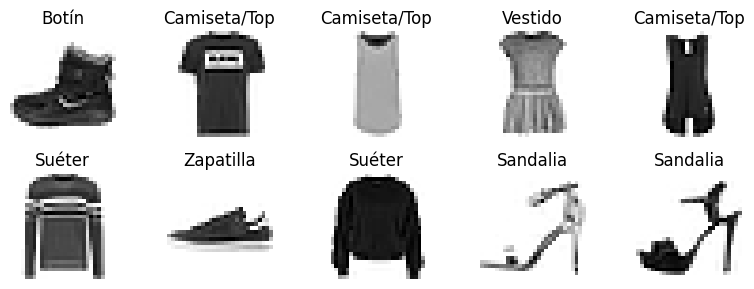

In [7]:
#FASHION MNIST
#Etiquetas
class_names = ["Camiseta/Top", "Pantalón", "Suéter", "Vestido", "Abrigo",
               "Sandalia", "Camisa", "Zapatilla", "Bolso", "Botín"]

#Visualización
plt.figure(figsize=(8, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i].squeeze(), cmap='binary')
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.tight_layout(); plt.show()

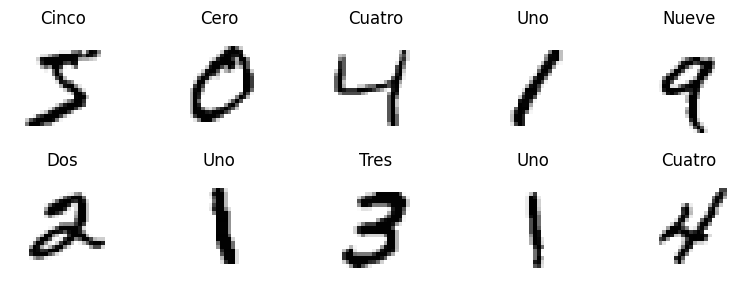

In [8]:
#MNIST-DIGITOS
#Etiquetas
classnames = ["Cero", "Uno", "Dos", "Tres", "Cuatro",
               "Cinco", "Seis", "Siete", "Ocho", "Nueve"]

#Visualización
plt.figure(figsize=(8, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(Xtrain[i].squeeze(), cmap='binary')
    plt.title(classnames[ytrain[i]])
    plt.axis('off')
plt.tight_layout(); plt.show()

# Ejercicios

## Punto 1
Grafique el espacio proyectado de PCA en 2D (etiquetas e imágenes) para los atributos aprendidos por la capa de concatenación.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ entrada             │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 784)       │          0 │ entrada[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h1 (Dense)          │ (None, 200)       │    157,000 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h2 (Dense)          │ (None, 50)        │     10,050 │ h1[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 834)       │          0 │ h2[0][0],         │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputA (Dense)     │ (None, 10)        │      8,350 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputB (Dense)     │ (None, 10)        │        510 │ h2[0][0]          │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 175,910 (687.15 KB)

 Trainable params: 175,910 (687.15 KB)

 Non-trainable params: 0 (0.00 B)

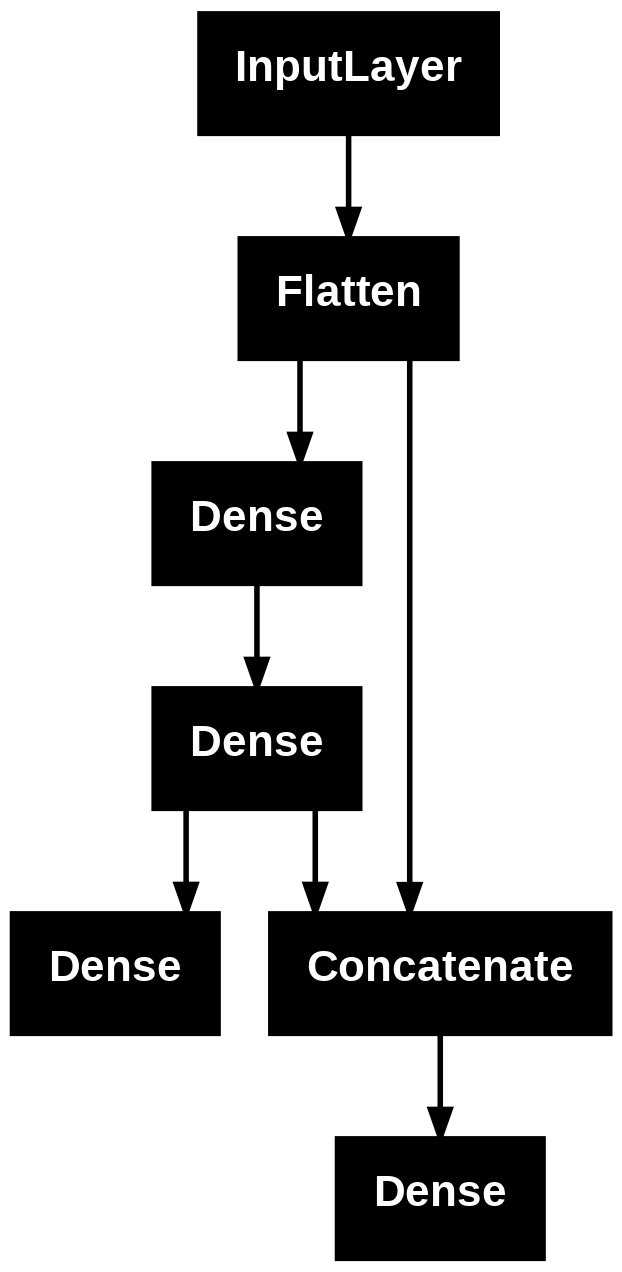

In [9]:
# Modelo de Entrenamiento
tf.keras.backend.clear_session()
input_l = tf.keras.layers.Input(shape=(X_train.shape[1],X_train.shape[2]), name='entrada')
flatten = tf.keras.layers.Flatten(input_shape=(X_train.shape[1],X_train.shape[2]))(input_l)

h1 = tf.keras.layers.Dense(200,activation='tanh',name='h1')(flatten)
h2 = tf.keras.layers.Dense(50,activation='tanh',name='h2')(h1)
#capa que concatena características extraídas en h2 con imágenes de entrada
concat = tf.keras.layers.concatenate([h2,flatten])
#se crean dos salidas:
output_A = tf.keras.layers.Dense(10,activation="softmax",name='outputA')(concat) #desde concatenación
output_B = tf.keras.layers.Dense(10,activation="softmax",name='outputB')(h2) #desde h2
model_fun = tf.keras.Model(inputs=input_l,outputs=[output_A, output_B])
model_fun.summary()
tf.keras.utils.plot_model(model_fun)

In [10]:
# Compilación del modelo
model_fun.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["accuracy","accuracy"])

In [11]:
# Entrenamiento del modelo
history = model_fun.fit(Xtrain, [ytrain,ytrain] , epochs=10,batch_size=64, validation_split=0.3)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 3.1508 - outputA_accuracy: 0.4455 - outputA_loss: 1.7840 - outputB_accuracy: 0.5988 - outputB_loss: 1.3667 - val_loss: 1.2512 - val_outputA_accuracy: 0.8187 - val_outputA_loss: 0.7446 - val_outputB_accuracy: 0.8693 - val_outputB_loss: 0.4995
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9920 - outputA_accuracy: 0.8646 - outputA_loss: 0.6011 - outputB_accuracy: 0.9068 - outputB_loss: 0.3909 - val_loss: 0.8670 - val_outputA_accuracy: 0.8867 - val_outputA_loss: 0.4700 - val_outputB_accuracy: 0.8853 - val_outputB_loss: 0.3918
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6734 - outputA_accuracy: 0.9057 - outputA_loss: 0.3892 - outputB_accuracy: 0.9289 - outputB_loss: 0.2842 - val_loss: 0.6904 - val_outputA_accuracy: 0.9027 - val_outputA_loss: 0.3678 - val_outputB_accuracy: 0.9113 - val_outputB_loss: 0.3158
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5132 - outputA_accuracy: 0.9210 - outpu

In [12]:
# Predicciones
yestA,yestB = model_fun.predict(Xtest)
print(yestA.shape,yestB.shape)

# Evaluación del modelo
scoreA = model_fun.evaluate(Xtest,[ytest,ytest])
print(scoreA)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
(10000, 10) (10000, 10)
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6443 - outputA_accuracy: 0.9033 - outputA_loss: 0.3233 - outputB_accuracy: 0.9024 - outputB_loss: 0.3210
[0.5765306949615479, 0.28850412368774414, 0.28771135210990906, 0.9164999723434448, 0.9158999919891357]


In [13]:
#Modelo con salida parcial en la capa de concatenación
concat_model = tf.keras.Model(inputs=model_fun.inputs,outputs=model_fun.get_layer('concatenate').output)
tf.keras.utils.plot_model(concat_model)
clear_output()

#Obtener salida intermedia (capa de concatenación)
z = concat_model.predict(X_test)
print(z.shape)

#Reducción de dimensión con PCA
zpca = PCA(n_components=2).fit_transform(z)
print(zpca.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(10000, 834)
(10000, 2)


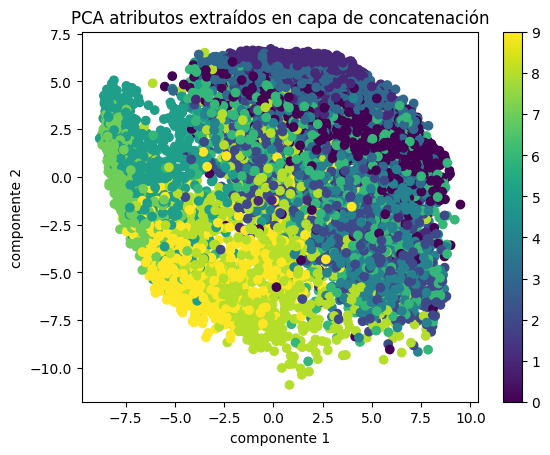

In [14]:
# Gráfica PCA en capa de concatenación
plt.scatter(zpca[:,0],zpca[:,1],c=y_test)
plt.colorbar()
plt.xlabel('componente 1'); plt.ylabel('componente 2')
plt.title('PCA atributos extraídos en capa de concatenación')
plt.show()

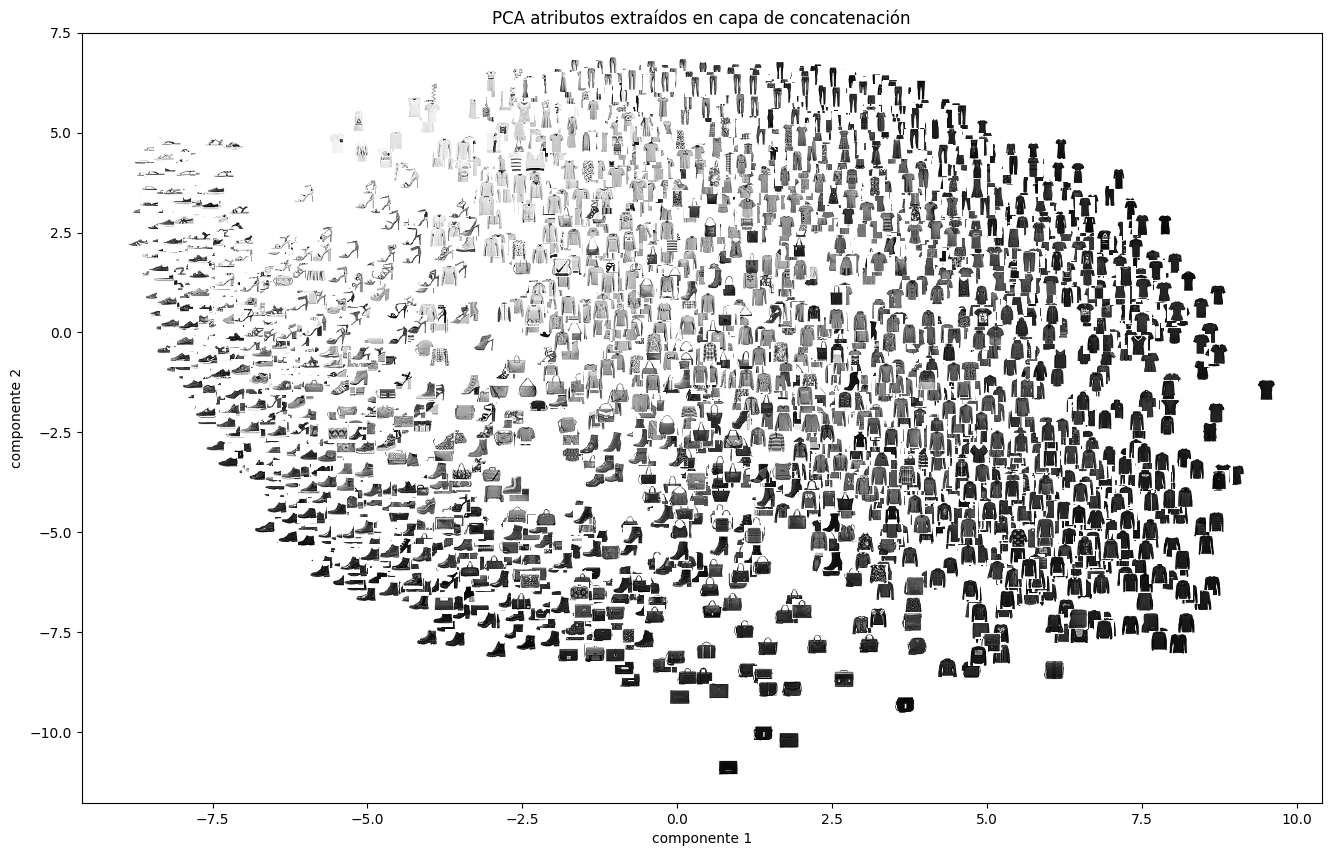

In [15]:
#Gráfica PCA en capa de concatenación en espacio 2D
Ni =4000; ind = np.random.randint(0,y_test.shape[0],Ni)
plot_mnist_2d(zpca[ind],y_test[ind],X_test[ind],img_w=28,img_h=28,zoom=0.5,cmap='binary')
plt.xlabel('componente 1'); plt.ylabel('componente 2')
plt.title('PCA atributos extraídos en capa de concatenación')
plt.show()

## Punto 2
Repita el proceso aplicando la técnica de reducción de dimensión UMAP de RAPIDS.

In [16]:
# Reducción de dimensión con UMAP (RAPIDS)
umap_model = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)

zumap = umap_model.fit_transform(z)
print(zumap.shape)

[2025-11-04 00:22:06.520] [CUML] [info] build_algo set to brute_force_knn because random_state is given
(10000, 2)


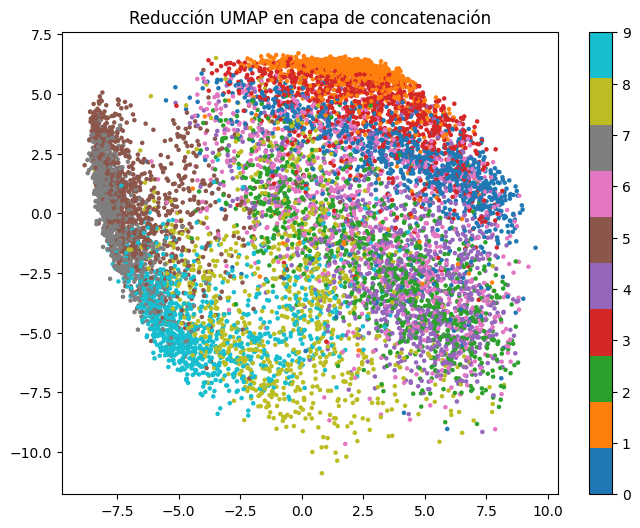

In [17]:
# Gráfica UMAP en capa de concatenación en espacio 2D
plt.figure(figsize=(8,6))
scatter = plt.scatter(zpca[:,0], zpca[:,1], c=y_test, cmap='tab10', s=5)
plt.title("Reducción UMAP en capa de concatenación")
plt.colorbar(scatter)
plt.show()

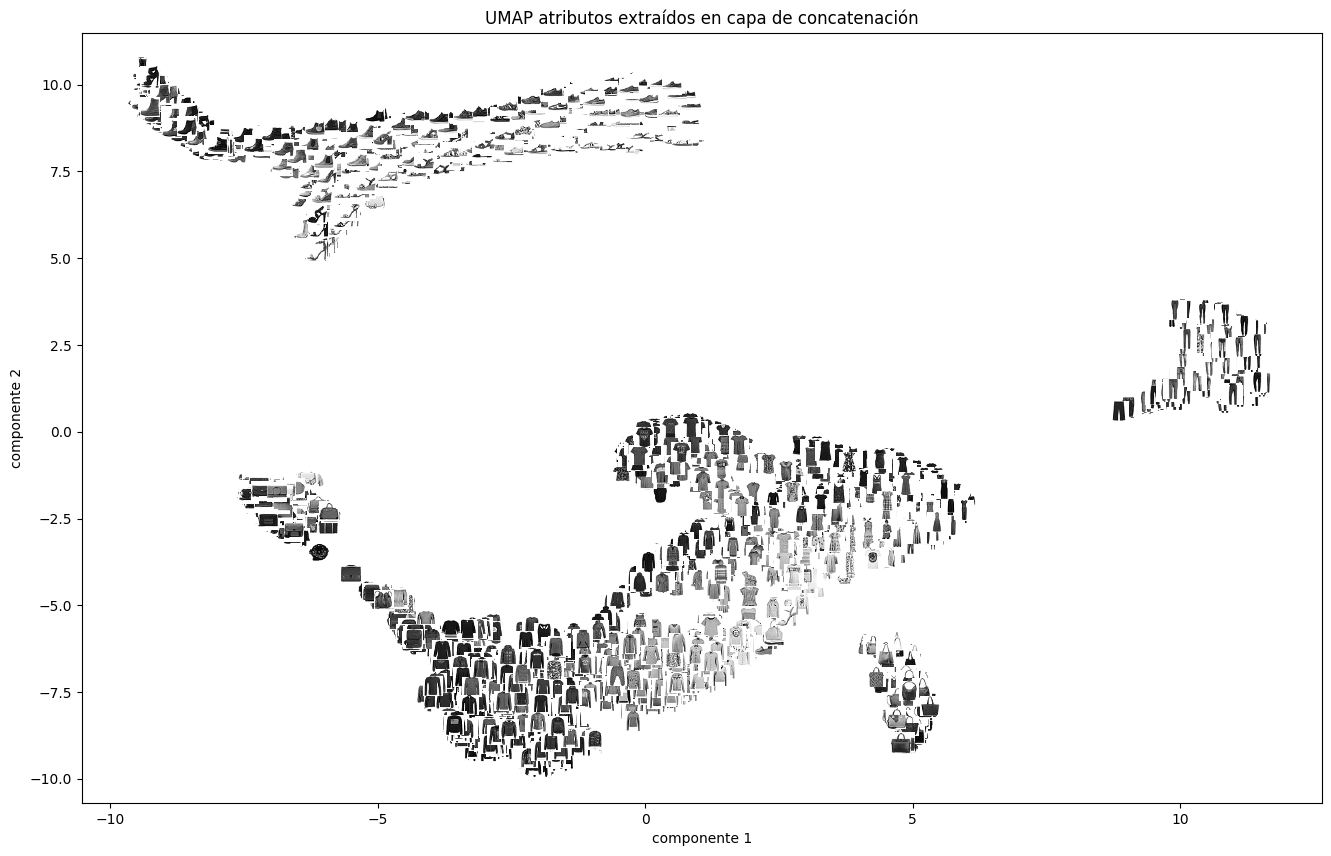

In [18]:
#Gráfica UMAP en capa de concatenación en espacio 2D
Ni =4000; ind = np.random.randint(0,y_test.shape[0],Ni)
plot_mnist_2d(zumap[ind],y_test[ind],X_test[ind],img_w=28,img_h=28,zoom=0.5,cmap='binary')
plt.xlabel('componente 1'); plt.ylabel('componente 2')
plt.title('UMAP atributos extraídos en capa de concatenación')
plt.show()

## Punto 3
Plantee una nueva arquitectura tipo funcional utilizando capas convolucionales para el entrenamiento de la base de datos Mnist-digitos, utilizando tres entradas: i) imágenes limpias, ii) y iii) imágenes con ruido blanco Gaussiano ante diferentes varianzas, y dos salidas i) estimación del digito, ii) estimación número par número impar.

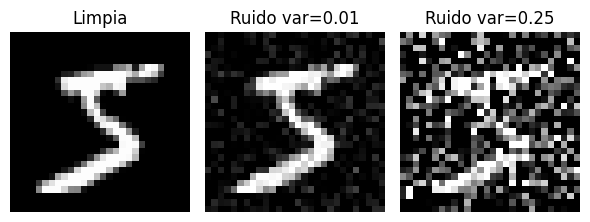

In [19]:
#Crear entradas con y sin ruido
var = [0.01,0.25]

# Generar listas de entradas (limpia + 2 con ruido)
inputs_train = [Xtrain] + [gaussian_noise(Xtrain, v) for v in var]
inputs_valid = [Xvalid] + [gaussian_noise(Xvalid, v) for v in var]
inputs_test  = [Xtest]  + [gaussian_noise(Xtest, v) for v in var]

# Visualización de ejemplo
idx = 0  # índice de imagen a visualizar
plt.figure(figsize=(6,3))
titles = ['Limpia', f'Ruido var={var[0]}', f'Ruido var={var[1]}']
for i, data in enumerate(inputs_train):
    plt.subplot(1, 3, i + 1)
    plt.imshow(data[idx, :, :, 0], cmap='gray')
    plt.title(titles[i]); plt.axis('off')
plt.tight_layout(); plt.show()

In [20]:
# Primer salida: dígito (10 clases)
ytrain_10 = ytrain
yvalid_10 = yvalid
ytest_10  = ytest

# Segunda salida: 0 si par, 1 si impar (2 clases)
ytrain_B = (ytrain % 2)
yvalid_B = (yvalid % 2)
ytest_B  = (ytest % 2)

print(ytrain_B[10:]); print(ytrain[10:])

[1 1 1 ... 0 1 0]
[3 5 3 ... 2 1 2]


In [21]:
tf.keras.backend.clear_session()

# Entradas
input_1 = tf.keras.layers.Input(shape=(Xtrain.shape[1], Xtrain.shape[2], Xtrain.shape[3]), name='entrada_1')
input_2 = tf.keras.layers.Input(shape=(Xtrain.shape[1], Xtrain.shape[2], Xtrain.shape[3]), name='entrada_2')
input_3 = tf.keras.layers.Input(shape=(Xtrain.shape[1], Xtrain.shape[2], Xtrain.shape[3]), name='entrada_3')

# Base convolucional entrada uno (imagenes originales)
conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(input_1)
maxpool_1 = tf.keras.layers.MaxPooling2D(pool_size=2)(conv_1)
conv2_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(maxpool_1)
maxpool2_1 = tf.keras.layers.MaxPooling2D(pool_size=2)(conv2_1)
flatten_1 = tf.keras.layers.Flatten()(maxpool2_1)

# Base convolucional entrada 2 (imagenes con ruido 0.01)
conv_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(input_2)
maxpool_2 = tf.keras.layers.MaxPooling2D(pool_size=2)(conv_2)
conv2_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(maxpool_2)
maxpool2_2 = tf.keras.layers.MaxPooling2D(pool_size=2)(conv2_2)
flatten_2 = tf.keras.layers.Flatten()(maxpool2_2)

# Base convolucional entrada 3 (imagenes con ruido 0.25)
conv_3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(input_3)
maxpool_3 = tf.keras.layers.MaxPooling2D(pool_size=2)(conv_3)
conv2_3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(maxpool_3)
maxpool2_3 = tf.keras.layers.MaxPooling2D(pool_size=2)(conv2_3)
flatten_3 = tf.keras.layers.Flatten()(maxpool2_3)

# Concatenación
concat = tf.keras.layers.concatenate([flatten_1, flatten_2, flatten_3])

# Capas densas despues de concatenar
dense = tf.keras.layers.Dense(128, activation='relu')(concat)
dropout = tf.keras.layers.Dropout(0.5)(dense)

# Definir las dos salidas
output_d = tf.keras.layers.Dense(10, activation='softmax', name='output_digit')(dropout) # 10 clases de digitos
output_b = tf.keras.layers.Dense(1, activation='sigmoid', name='output_parity')(dropout) # 0 para par, 1 para impar

# Crear el modelo
model_cnn = tf.keras.Model(inputs=[input_1, input_2, input_3], outputs=[output_d, output_b])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ entrada_1           │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entrada_2           │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entrada_3           │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        320 │ entrada_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │        320 │ entrada_2[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │        320 │ entrada_3[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 14, 14,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 14, 14,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 7, 7, 64)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 7, 7, 64)  │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 3136)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,262,219 (4.81 MB)

 Trainable params: 1,262,219 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

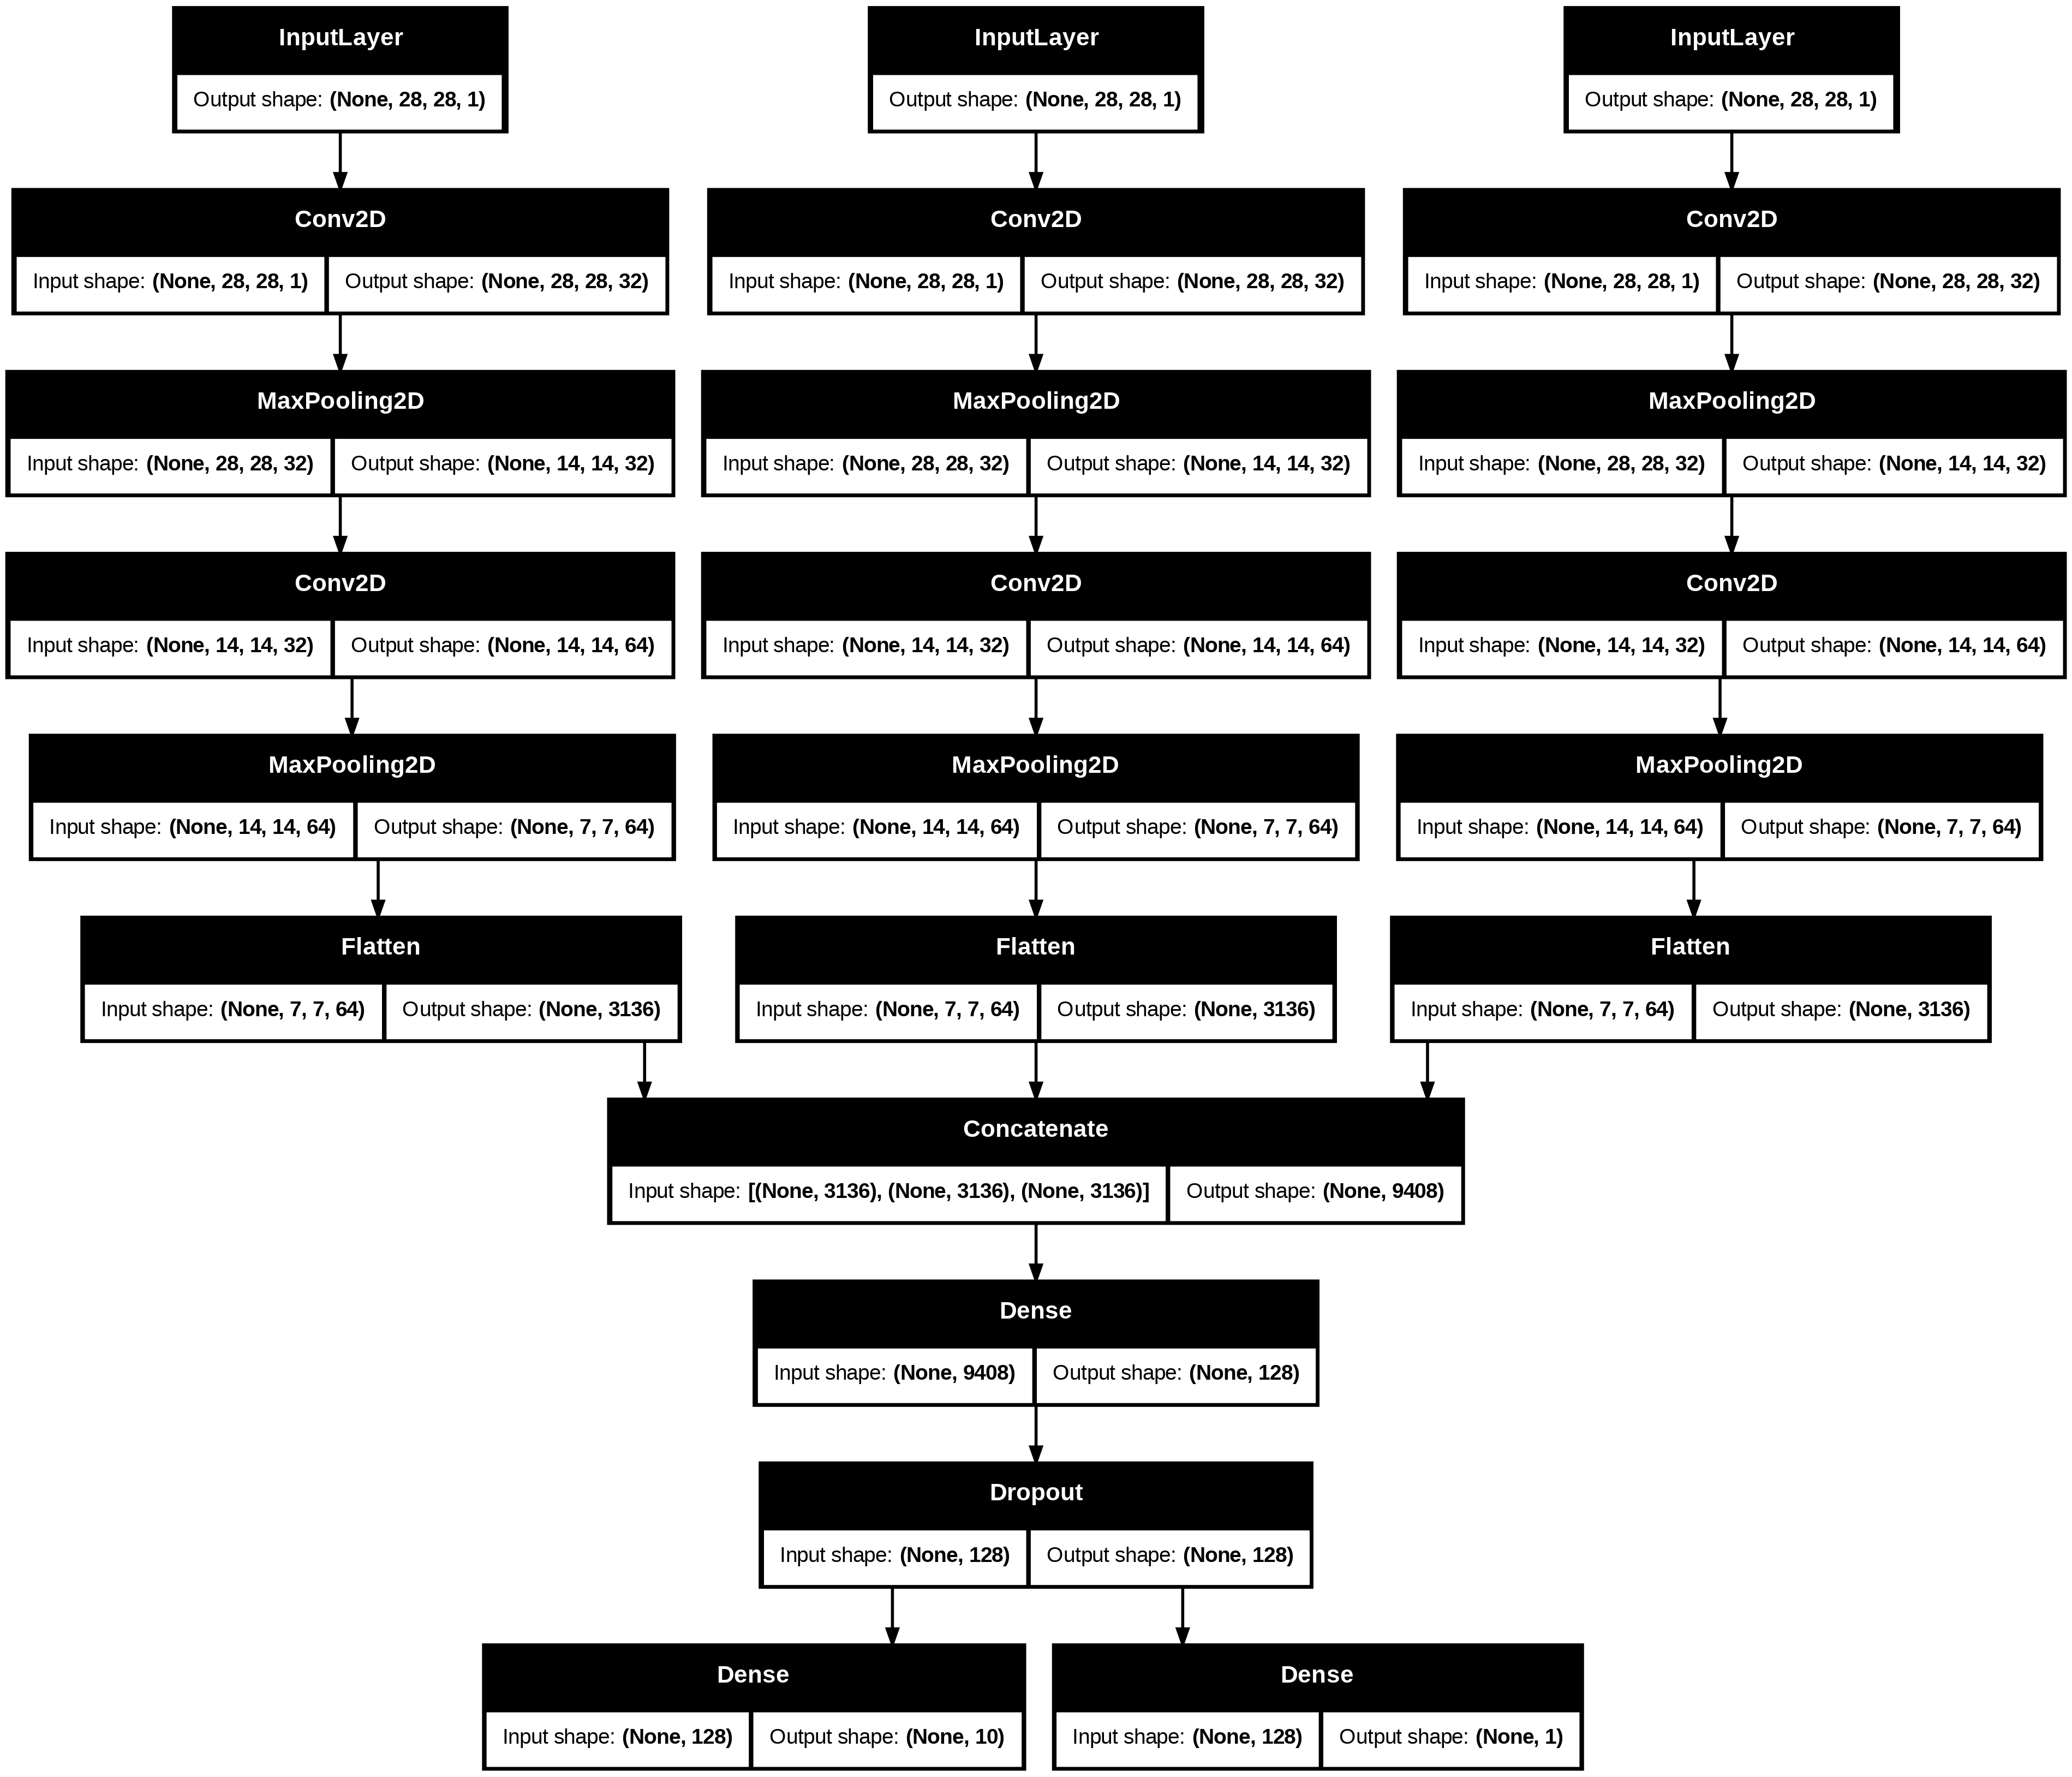

In [22]:
# Resumen visual
model_cnn.summary()
tf.keras.utils.plot_model(model_cnn, show_shapes=True)

In [23]:
# Compilación del modelo
model_cnn.compile(loss=["sparse_categorical_crossentropy", "binary_crossentropy"], optimizer="nadam", metrics=["accuracy", "accuracy"])

In [24]:
# Entrenamiento del modelo
history = model_cnn.fit([inputs_train[0], inputs_train[1], inputs_train[2]], [ytrain, (ytrain_B)],
                            epochs=10,
                            validation_data=([inputs_valid[0], inputs_valid[1], inputs_valid[2]],
                                             [yvalid, (yvalid_B)]))

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - loss: 1.7812 - output_digit_accuracy: 0.5582 - output_digit_loss: 1.3321 - output_parity_accuracy: 0.7622 - output_parity_loss: 0.4491 - val_loss: 0.3357 - val_output_digit_accuracy: 0.9351 - val_output_digit_loss: 0.2236 - val_output_parity_accuracy: 0.9604 - val_output_parity_loss: 0.1121
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.4235 - output_digit_accuracy: 0.9119 - output_digit_loss: 0.2977 - output_parity_accuracy: 0.9538 - output_parity_loss: 0.1258 - val_loss: 0.2209 - val_output_digit_accuracy: 0.9554 - val_output_digit_loss: 0.1513 - val_output_parity_accuracy: 0.9757 - val_output_parity_loss: 0.0696
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.2980 - output_digit_accuracy: 0.9373 - output_digit_loss: 0.2166 - output_parity_accuracy: 0.9702 - output_parity_loss: 0.0814 - val_loss: 0.2014 - val_output_digit_accuracy: 0.9586 - val_output_digit_loss: 0.1302 - val_output_parity_accurac

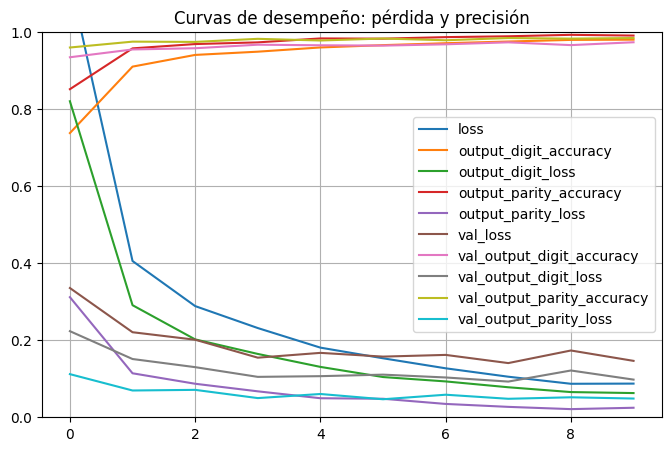

In [25]:
# Curvas de desempeño
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True); plt.gca().set_ylim(0, 1)
plt.title("Curvas de desempeño: pérdida y precisión")
plt.show()

In [26]:
# Evaluación del modelo
score = model_cnn.evaluate([inputs_test[0], inputs_test[1], inputs_test[2]],
                                 [ytest, (ytest_B)])
print("Test loss and accuracy:", score)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1292 - output_digit_accuracy: 0.9726 - output_digit_loss: 0.0892 - output_parity_accuracy: 0.9865 - output_parity_loss: 0.0400
Test loss and accuracy: [0.10837232321500778, 0.07320887595415115, 0.03502318635582924, 0.9769999980926514, 0.9883000254631042]


In [32]:
# Predicciones
preds = model_cnn.predict([inputs_test[0], inputs_test[1], inputs_test[2]])

digit_preds = np.argmax(preds[0], axis=1)
parity_preds = np.round(preds[1]).flatten()

print("\nPredicciones de clase (0-9):", digit_preds[:10])
print("Valores reales de clase (0-9):", y_test[:10])
print("\nPredicciones par/impar:", parity_preds[:10])
print("Valores reales par/impar:", (ytest_B)[:10])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Predicciones de clase (0-9): [7 2 1 0 4 1 4 9 5 9]
Valores reales de clase (0-9): [9 2 1 1 6 1 4 6 5 7]

Predicciones par/impar: [1. 0. 1. 0. 0. 1. 0. 1. 1. 1.]
Valores reales par/impar: [1 0 1 0 0 1 0 1 1 1]
